In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Data Loading and Preprocessing

In [159]:
df=pd.read_csv("dataset/train_set_rec.csv")

In [160]:
df

,Timestamp,KPI_Value,Status,KPI_Name
0,2017-04-30 16:00:00,1.901639,0,Stamping Press Efficiency
1,2017-04-30 16:01:00,1.786885,0,Stamping Press Efficiency
2,2017-04-30 16:02:00,2.000000,0,Stamping Press Efficiency
3,2017-04-30 16:03:00,1.885246,0,Stamping Press Efficiency
4,2017-04-30 16:04:00,1.819672,0,Stamping Press Efficiency
...,...,...,...,...
1075526,2016-11-23 03:35:00,0.146835,0,Maintenance Cost per Unit
1075527,2016-11-23 03:40:00,0.149247,0,Maintenance Cost per Unit
1075528,2016-11-23 03:45:00,0.148245,0,Maintenance Cost per Unit
1075529,2016-11-23 03:50:00,0.148031,0,Maintenance Cost per Unit


In [161]:
df.shape

(1075531, 4)

In [162]:
df['KPI_Name'].unique()

array(['Stamping Press Efficiency', 'Welding Robot Efficiency',
       'CNC Machine Utilization', 'Painting Robot Performance',
       'Assembly Line Speed', 'Quality Control Defect Rate',
       'Material Waste Percentage', 'Energy Consumption per Unit',
       'Machine Downtime', 'Operator Efficiency',
       'Inventory Turnover Rate', 'Production Yield Rate',
       'Maintenance Cost per Unit'], dtype=object)

In [163]:
# convert timestamp to datetime
from sqlalchemy import asc


df['Timestamp'] = pd.to_datetime(df['Timestamp'] )

# sort by timestamp
df = df.sort_values(by='Timestamp',ascending=True)

# set timestamp as index
df.index = df['Timestamp']

In [164]:
df.describe(include='all')

C:\Users\E15\AppData\Local\Temp\ipykernel_13524\2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Timestamp,KPI_Value,Status,KPI_Name
count,1075531,1.075531e+06,1.075531e+06,1075531
unique,153217,NaN,NaN,13
top,2017-06-07 23:26:00,NaN,NaN,Assembly Line Speed
freq,8,NaN,NaN,129128
first,2016-06-30 16:00:00,NaN,NaN,NaN
last,2017-07-31 04:34:00,NaN,NaN,NaN
mean,NaN,2.487058e+08,3.386606e-02,NaN
std,NaN,4.475774e+08,1.808844e-01,NaN
min,NaN,-4.546069e+00,0.000000e+00,NaN
25%,NaN,1.937500e+00,0.000000e+00,NaN


In [165]:
# verify the number of missing values in each column
nan_values = df.isna().sum()
nan_values>0

Timestamp    False
KPI_Value    False
Status       False
KPI_Name     False
dtype: bool

C:\Users\E15\AppData\Local\Temp\ipykernel_13524\3664052485.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['KPI_Value'], shade=True, color='b')


<Axes: xlabel='KPI_Value', ylabel='Density'>

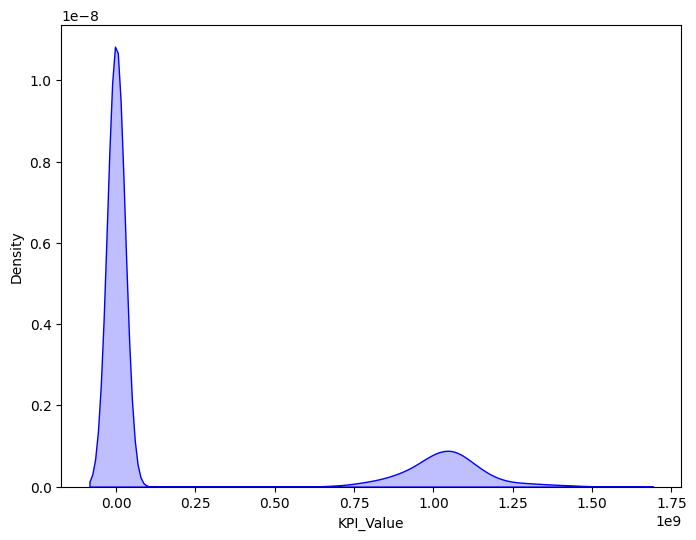

In [166]:
# plot the distribution of KPI values
plt.figure(figsize=(8, 6))
sns.kdeplot(df['KPI_Value'], shade=True, color='b')

In [167]:
# since the standard deviation is very high, we will normalize the KPI values
# using min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df['KPI_Value'] = scaler.fit_transform(df[['KPI_Value']])

In [168]:
# normalizing KPI values
df['KPI_Value'].describe()

count    1.075531e+06
mean     1.545896e-01
std      2.782034e-01
min      0.000000e+00
25%      4.030032e-09
50%      6.337633e-09
75%      8.467318e-07
max      1.000000e+00
Name: KPI_Value, dtype: float64

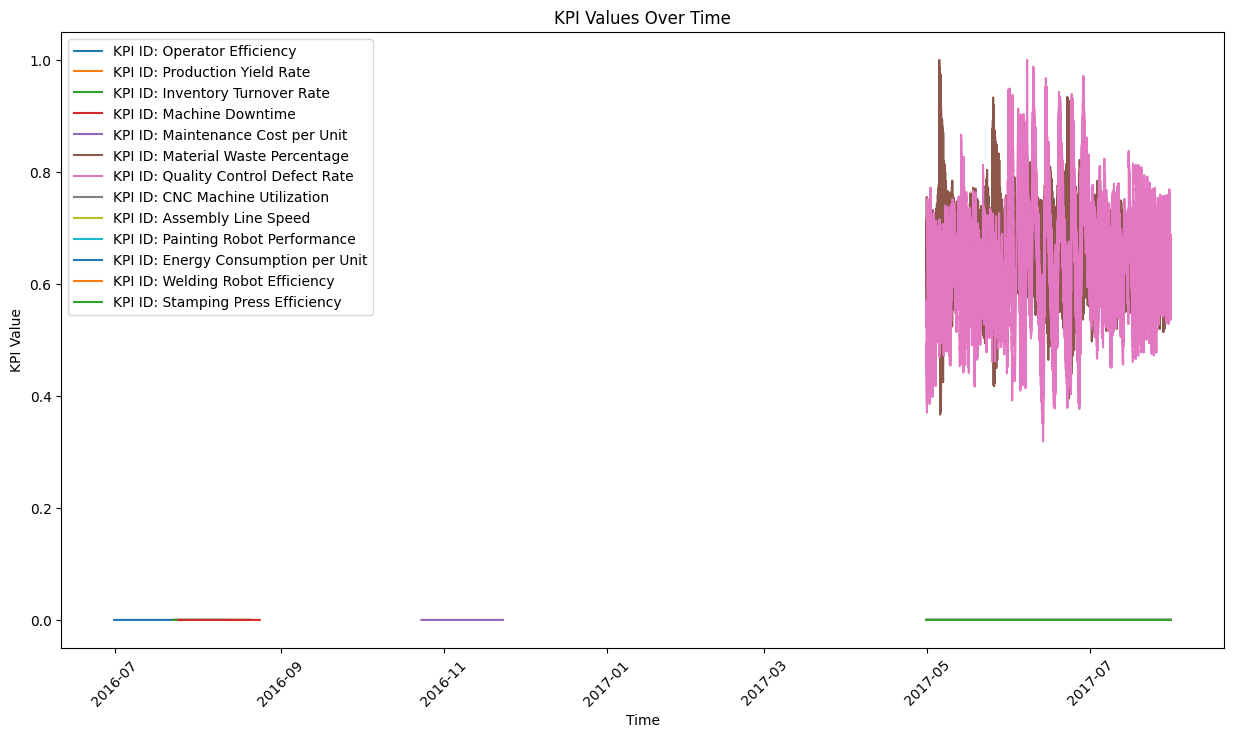

In [169]:
# Plot scaled KPI values over time for each KPI ID
unique_kpis = df['KPI_Name'].unique()

plt.figure(figsize=(15, 8))

for kpi in unique_kpis:
    plt.plot(df[df['KPI_Name'] == kpi]['Timestamp'], df[df['KPI_Name'] == kpi]['KPI_Value'], label=f'KPI ID: {kpi}')

plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('KPI Values Over Time')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()

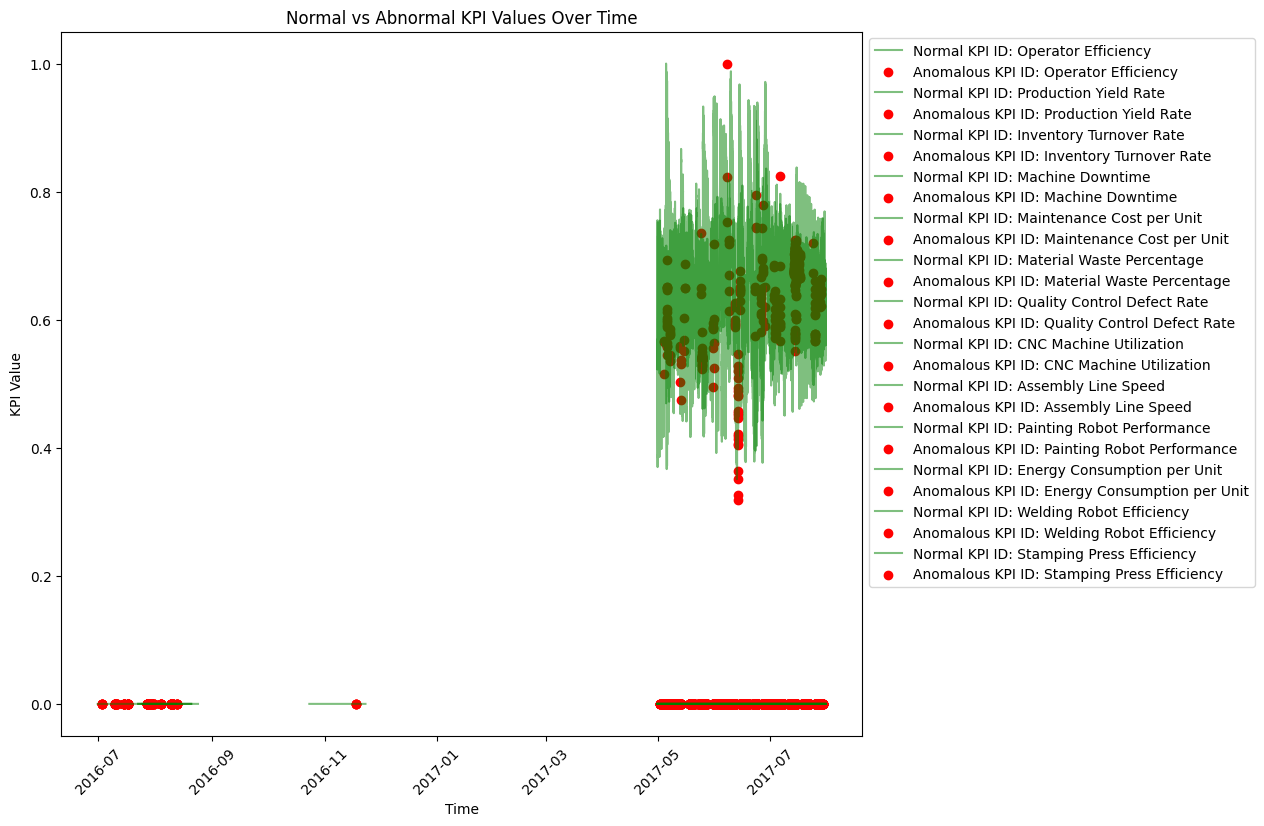

In [170]:
# Separate normal and abnormal data points
normal_data = df[df['Status'] == 0]
abnormal_data = df[df['Status'] == 1]

# Plot normal and abnormal points
plt.figure(figsize=(15, 8))


for kpi in unique_kpis:
    plt.plot(normal_data[normal_data['KPI_Name'] == kpi]['Timestamp'], 
             normal_data[normal_data['KPI_Name'] == kpi]['KPI_Value'], 
             label=f'Normal KPI ID: {kpi}', color='green', alpha=0.5)
    
    plt.scatter(abnormal_data[abnormal_data['KPI_Name'] == kpi]['Timestamp'], 
                abnormal_data[abnormal_data['KPI_Name'] == kpi]['KPI_Value'], 
                label=f'Anomalous KPI ID: {kpi}', color='red')
    
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('Normal vs Abnormal KPI Values Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=45)
plt.show()


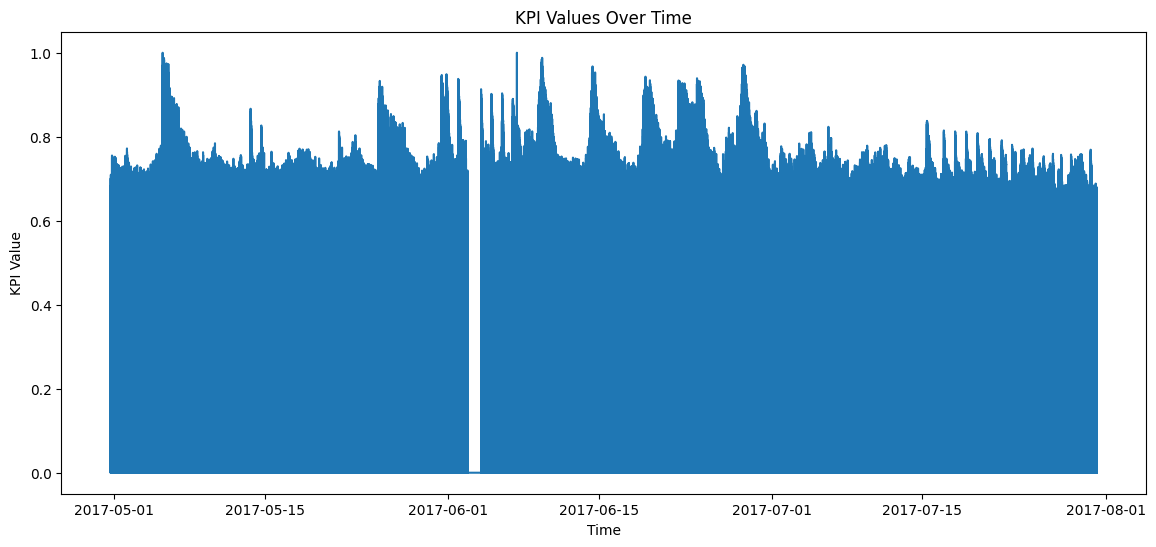

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df[df['Timestamp'] >= '2017-04-01']['KPI_Value'])
plt.title('KPI Values Over Time')
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.show()

# Feature Engineering

In [172]:
# Create time series sequences
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [173]:
time_step = 10
X, y = create_dataset(df[['KPI_Value']].values.reshape(-1,1), time_step=time_step)
X=X.reshape(X.shape[0],X.shape[1],1)

# Model Selection and Training

In [174]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')


tensorflow WARNING From c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

tensorflow WARNING From c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

tensorflow WARNING From c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100


tensorflow WARNING From c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse the normalization
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the true values for comparison
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[:train_size], y_train_actual, label='Actual Train', color='blue')
plt.plot(df.index[train_size:], y_test_actual, label='Actual Test', color='orange')
plt.plot(df.index[:train_size], train_predict, label='Predicted Train', color='lightblue')
plt.plot(df.index[train_size:], test_predict, label='Predicted Test', color='red')
plt.title('KPI Value Forecasting with LSTM')
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.legend()
plt.show()


In [ ]:
# Calculate errors
test_errors = np.abs(test_predict.flatten() - y_test_actual.flatten())

# Set a threshold for anomaly detection
threshold = np.mean(test_errors) + 2 * np.std(test_errors)
anomalies = test_errors > threshold

# Visualize anomalies
plt.figure(figsize=(14, 6))
plt.plot(df.index[train_size:], y_test_actual, label='Actual Test', color='orange')
plt.plot(df.index[train_size:], test_predict, label='Predicted Test', color='red')
plt.scatter(df.index[train_size:][anomalies], y_test_actual[anomalies], color='green', label='Anomalies')
plt.title('Anomaly Detection in KPI Forecasting')
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.legend()
plt.show()
